In [14]:
import numpy as np
import corner
import emcee
import matplotlib.pyplot as plt
import scipy.special as sp

In [281]:
lam = 3
samples = np.random.poisson( lam = lam , size = 10000 )

In [282]:
np.max( samples )

12

In [283]:
lbins = np.linspace( 0 , 20 , 21 )
count, _ = np.histogram( samples , bins = lbins )

In [284]:
lbins

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20.])

In [285]:
lcent = ( lbins[1:] + lbins[:-1] )/2.

In [286]:
lcent

array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
       11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5])

In [287]:
def poiss( x , l ):
    return l**x * np.exp(-l) / sp.factorial( x )

def gauss( x , mu , sig ):
    sig2 = sig**2
    return np.exp( -0.5 * ( x - mu )**2 / sig2 ) / np.sqrt( 2 * np.pi * sig2 )

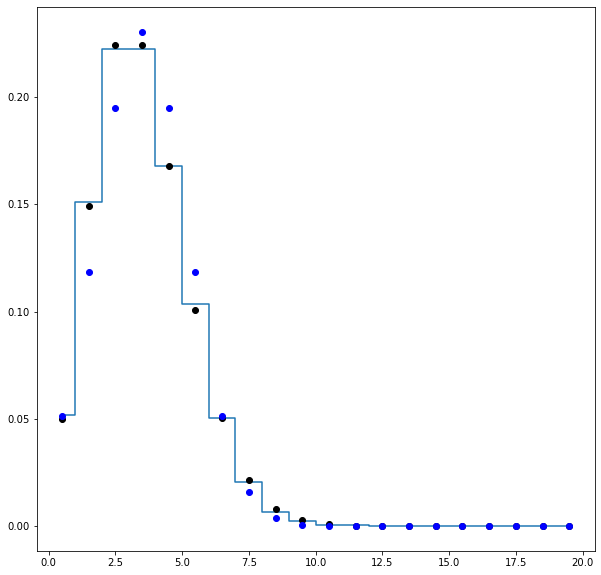

In [288]:
plt.figure( figsize = ( 10 , 10 ))
plt.plot( lcent , count / np.sum( count ), drawstyle='steps-mid' )
plt.plot( lcent , poiss( lcent - 0.5 , lam ) , 'ko' )
plt.plot( lcent , gauss( lcent - 0.5 , lam , lam**0.5 ) , 'bo' )

Estimate the value of $\lambda$ with each likelihood.

In [289]:
def ln_likelihood_poiss(  lam , x ):
    return -len( x ) * lam + np.sum( x ) * np.log( lam )# - sp.factorial( x )

In [309]:
def ln_likelihood_gauss(  lam , x , c = 1):
    return -0.5 * np.sum( x - lam )**2/ ( lam * c )

In [291]:
lam

3

In [292]:
pos = lam + 1e-4 * np.random.randn(32, 1)
nwalkers, ndim = pos.shape

sampler_poiss = emcee.EnsembleSampler(
    nwalkers, ndim, ln_likelihood_poiss, args=( samples , )
)

sampler_gauss = emcee.EnsembleSampler(
    nwalkers, ndim, ln_likelihood_gauss, args=( lam**0.5 ,  samples , )
)

In [293]:
sampler_poiss.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:06<00:00, 750.08it/s]


In [294]:
sampler_gauss.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:07<00:00, 683.96it/s]


In [295]:
mcmc_samples = sampler_gauss.get_chain()

mcmc_samples.shape

(5000, 32, 1)

Text(0.5, 0, 'steps')

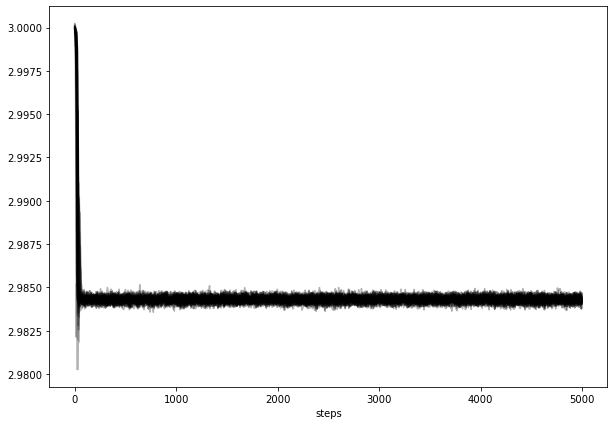

In [296]:
plt.figure(figsize=(10, 7))
mcmc_samples = sampler_gauss.get_chain()
plt.plot(mcmc_samples[:,:,0], "k", alpha=0.3)
plt.xlabel('steps')

Text(0.5, 0, 'steps')

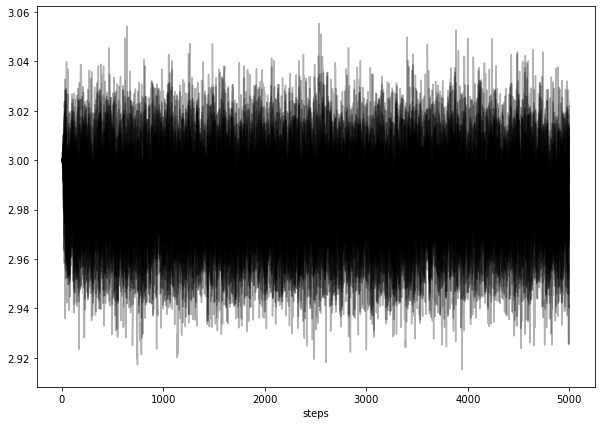

In [297]:
plt.figure(figsize=(10, 7))
mcmc_samples = sampler_poiss.get_chain()
plt.plot(mcmc_samples[:,:,0], "k", alpha=0.3)
plt.xlabel('steps')

In [298]:
sampler_poiss.get_autocorr_time()

array([27.08636702])

In [299]:
sampler_gauss.get_autocorr_time()

array([31.98767251])

In [300]:
flat_samples_poiss = sampler_poiss.get_chain(discard=100, thin=40, flat=True)
print(flat_samples_gauss.shape)

(3904, 1)


In [301]:
flat_samples_gauss = sampler_gauss.get_chain(discard=100, thin=40, flat=True)
print(flat_samples_gauss.shape)

(3904, 1)


In [302]:
est_l_bins = np.linspace( 2.9 , 3.1 , 1000 )
count_samples_poiss, _ = np.histogram( flat_samples_poiss , bins = est_l_bins )
count_samples_gauss, _ = np.histogram( flat_samples_gauss , bins = est_l_bins )

In [303]:
est_l_cent = ( est_l_bins[1:] + est_l_bins[:-1] )/2.

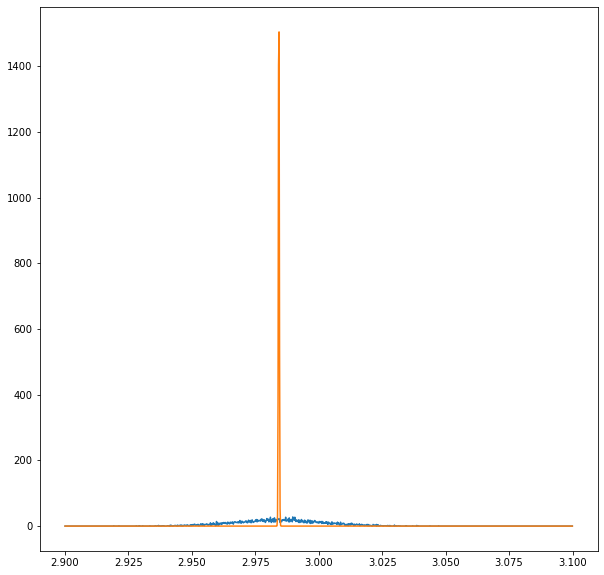

In [304]:
plt.figure( figsize = ( 10 , 10 ) )
plt.plot( est_l_cent , count_samples_poiss )
plt.plot( est_l_cent , count_samples_gauss )

In [305]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples_poiss[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))


<IPython.core.display.Math object>

In [306]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples_gauss[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

In [307]:
np.mean( flat_samples_poiss[:,0] ) , np.mean( flat_samples_gauss[:,0] )

(2.984219904093609, 2.9843004776232216)

In [308]:
np.std( flat_samples_poiss[:,0] ) , np.std( flat_samples_gauss[:,0] )

(0.01731256406206565, 0.0001762225276343134)

Do this 100 times and see the dispersion of the means

In [319]:
def get_means_and_vars():
    lam = 3
    samples = np.random.poisson( lam = lam , size = 100 )
    
    pos = lam + 1e-4 * np.random.randn(32, 1)
    nwalkers, ndim = pos.shape
    
    sampler_poiss = emcee.EnsembleSampler(
    nwalkers, ndim, ln_likelihood_poiss, args=( samples , )
    )

    sampler_gauss = emcee.EnsembleSampler(
        nwalkers, ndim, ln_likelihood_gauss, args=( samples , )
    )
    
    sampler_gauss_low = emcee.EnsembleSampler(
        nwalkers, ndim, ln_likelihood_gauss, args=( samples , 0.001 )
    )
    
    sampler_gauss_high = emcee.EnsembleSampler(
        nwalkers, ndim, ln_likelihood_gauss, args=( samples , 10 )
    )
    
    sampler_poiss.run_mcmc(pos, 5000, progress=False);
    sampler_gauss.run_mcmc(pos, 5000, progress=False);
    sampler_gauss_low.run_mcmc(pos, 5000, progress=False);
    sampler_gauss_high.run_mcmc(pos, 5000, progress=False);
    
    flat_samples_poiss = sampler_poiss.get_chain(discard=100, thin=40, flat=True)
    flat_samples_gauss = sampler_gauss.get_chain(discard=100, thin=40, flat=True)
    flat_samples_gauss_low = sampler_gauss_low.get_chain(discard=100, thin=40, flat=True)
    flat_samples_gauss_high = sampler_gauss_high.get_chain(discard=100, thin=40, flat=True)
    
    mean_poiss = np.mean( flat_samples_poiss[:,0] ) 
    mean_gauss = np.mean( flat_samples_gauss[:,0] )
    mean_gauss_low = np.mean( flat_samples_gauss_low[:,0] )
    mean_gauss_high = np.mean( flat_samples_gauss_high[:,0] )
    
    std_poiss = np.std( flat_samples_poiss[:,0] ) 
    std_gauss = np.std( flat_samples_gauss[:,0] ) 
    std_gauss_low = np.std( flat_samples_gauss_low[:,0] )
    std_gauss_high = np.std( flat_samples_gauss_high[:,0] )
    
    return mean_poiss , mean_gauss , mean_gauss_low , mean_gauss_high , std_poiss , std_gauss , std_gauss_low , std_gauss_high


In [320]:
poiss_means = []
poiss_stds = []

gauss_means = []
gauss_stds = []

gauss_low_means = []
gauss_low_stds = []

gauss_high_means = []
gauss_high_stds = []


for i in np.arange( 0 , 1000 ):
    print( i )
    l_poiss, l_gauss , lgl , lgh , sig_poiss , sig_gauss , sgl , sgh = get_means_and_vars()
    poiss_means.append( l_poiss )
    poiss_stds.append( sig_poiss )
    
    gauss_means.append( l_gauss )
    gauss_stds.append( sig_gauss )
    
    gauss_low_means.append( lgl )
    gauss_low_stds.append( sgl )
    
    gauss_high_means.append( lgh )
    gauss_high_stds.append( sgh )

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
28

Compare the posterior mean dispersion to the individual estimated variance

In [321]:
np.mean( poiss_means ), np.mean( gauss_means ), np.mean( gauss_low_means ), np.mean( gauss_high_means )

(3.0191116084366683, 3.0095690383140177, 3.009420188354997, 3.0108959738558108)

In [322]:
np.std( poiss_means ), np.std( gauss_means ), np.std( gauss_low_means ), np.std( gauss_high_means )

(0.1750597584195543,
 0.17489093983192414,
 0.17491490848915708,
 0.17488065265485303)

In [323]:
np.mean( poiss_stds ) , np.mean( gauss_stds ), np.mean( gauss_low_stds ), np.mean( gauss_high_stds )

(0.17270396384112874,
 0.017249206704214374,
 0.0005452803066602006,
 0.05457275429356918)

In [262]:
np.mean( samples ) , np.std( samples )/len(samples)**0.5

(2.9823, 0.017230747836353474)